# 方案一：CNN整体表示+LSTM

### 一、导入模块

In [1]:
from datetime import datetime, timedelta
import os
import json
import random
import logging
import warnings
from typing import List, Set, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import torch.nn as nn
from torch import distributions
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import spacy
from rouge import Rouge

### 二、加载/构建词表

In [2]:
class OOVWarning(Warning):
    pass


class EndLabelNotFoundWarning(Warning):
    pass


class Vocabulary:
    def __init__(self, json_filepath):
        with open(json_filepath, 'rb') as fp:
            self._content: dict = json.load(fp)  # str -> int
        self.inv = {v: k for k, v in self._content.items()}  # int -> str

        self.pad: int = self._content['<pad>']  # int
        self.start: int = self._content['<start>']  # int
        self.end: int = self._content['<end>']  # int
        self.unk: int = self._content['<unk>']  # int
        self.spec_words: Set[int] = {self.pad, self.start, self.end, self.unk}  # 特殊字符
        self.size = len(self._content)
        self.nlp = spacy.load("en_core_web_sm")

    @staticmethod
    def build(raw_documents: List[str], save_path):
        """
        Vocabulary Factory
        :param raw_documents:
        :param save_path:
        :return:
        """
        content = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        nlp = spacy.load("en_core_web_sm")
        for raw_document in tqdm(raw_documents):
            for token in nlp(raw_document):
                if token.text.lower() not in content:
                    content[token.text.lower()] = len(content)
        with open(save_path, 'w') as fw:
            json.dump(content, fw)
        return Vocabulary(save_path)

    def __len__(self):
        return len(self._content)

    def __getitem__(self, word):
        if word in self._content:
            return self._content[word]
        else:
            warnings.warn(f'词表之外的词汇\"{word}\"，被编码为 <unk>', OOVWarning)
            return self.unk

    def get_word2vec(self, cache_path='word2vec.npy'):
        """获取词表的词向量嵌入, spacy提供的支持，固定提供96维词嵌入"""
        try:
            return np.load(cache_path)
        except FileNotFoundError:
            logging.log(0, 'building word2vec matrix...')
            word2vecs = []
            for idx, word in self.inv.items():
                word2vecs.append(
                    self.nlp(word)[0].tensor if idx not in self.spec_words else np.random.randn(96))  # nlp提供96维嵌入
            np.save(cache_path, np.array(word2vecs))
            return np.array(word2vecs)

    @staticmethod
    def post_process(string: str):
        s1 = string.replace(' .', '.').replace(' ,', ',').replace(' -', '-').replace('- ', '-')  # 标点间隔0
        s2 = s1[0].upper() + s1[1:]  # 开头大写
        return s2

    def encode(self, sentence, fixed_length=None) -> List[int]:
        """
        将文本编码为序列
        :param sentence:
        :param
        :return:
        """
        indices = [self.start] + [self[token.text.lower()] for token in self.nlp(sentence)] + [self.end]
        if fixed_length is not None:
            indices = (indices + [self.pad] * (fixed_length - len(indices)))[:fixed_length]
        return indices

    def decode(self, sequence: List[int]) -> str:
        """
        将序列解码为文本，跳过特殊字符，遇到终止符结束
        :param sequence:
        :return:
        """
        words = []
        for idx in sequence:
            if idx == self.end:
                break
            if idx not in self.inv:
                raise KeyError(f'索引{idx}超出了词表的范围，词表长度：{self.__len__()}')
            elif idx not in self.spec_words:  # 跳过特殊字符
                words.append(self.inv[idx])
        else:
            warnings.warn('没有在序列中发现终止符<end>', EndLabelNotFoundWarning)
        return self.post_process(' '.join(words))

In [3]:
root_dir = 'data/deepfashion-multimodal'

vocabulary = Vocabulary(os.path.join(root_dir, 'vocab.json'))
rouge = Rouge()

def calculate_rouge_l(text_output, standard_text):
    score = rouge.get_scores(text_output, standard_text)[0]['rouge-l']['f']
    return score

### 构建数据集

In [4]:
class ImageTextDataset(Dataset):
    def __init__(self, root_dir, vocabulary: Vocabulary, max_seq_len, transform=lambda x: x, train=True, split=True):
        """
        Args:
            root_dir (string): Root directory of the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        label_path = os.path.join(root_dir, f'{"train" if train else "test"}_captions{"_split" if split else ""}.json')
        with open(label_path, 'rb') as fp:
            self.filenames, self.labels = zip(*json.load(fp)) if split else zip(*json.load(fp).items())
        
        self.root_dir = root_dir
        
        self.vocabulary = vocabulary
        self.max_seq_len = max_seq_len
        self.transform = transform

        self.image_cache = {}

    def __len__(self):
        return len(self.filenames)
    
    def get_pair(self, idx):
        image_path = os.path.join(self.root_dir, 'images', self.filenames[idx])
        text_label = self.labels[idx]
        return image_path, text_label

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_path = os.path.join(self.root_dir, 'images', self.filenames[idx])
        if image_path not in self.image_cache:  # 如果图像不在缓存中
            image = self.transform(Image.open(image_path))
            self.image_cache[image_path] = image  # 缓存图像
        else:
            image = self.image_cache[image_path]  # 从缓存中获取图像
            
        indices = vocabulary.encode(self.labels[idx], fixed_length=self.max_seq_len)
        seq = torch.LongTensor(np.array(indices))
        
        return image, seq

### 三、构建模型

In [7]:
class ConvNet(nn.Module):
    def __init__(self, n_features, channels):
        """
        
        :param n_features: 输出特征维度
        :param channels: 图像通道数
        """
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        out_shape = (256, 8, 8)  # 根据实际输出尺寸进行调整
        out_dim = out_shape[0] * out_shape[1] * out_shape[2]
        self.fc = nn.Linear(in_features=out_dim, out_features=n_features)

    def forward(self, x):
        x = self.conv_layers(x)  # (batch, 128, 8, 8)
        x = x.view(x.size(0), -1)  # Flatten, (batch, 128*8*8)
        x = self.fc(x)
        return x  # (batch, n_features)


class ImageTextModel(nn.Module):
    """
    CNN整体表示+RNN
    """
    def __init__(self, vocabulary_size, channels, n_features, image_embed_dim, text_embed_dim, hidden_size=512, pretrained_embeddings=None):
        super(ImageTextModel, self).__init__()
        
        self.feat_extractor = ConvNet(n_features, channels)  # CNN整体表示
        
        if pretrained_embeddings is not None:
            assert pretrained_embeddings.shape == (vocabulary_size, text_embed_dim), "预训练嵌入向量尺寸不匹配"
            # 使用预训练的嵌入向量
            self.text_embed = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embeddings), freeze=False)
        else:
            # 随机初始化嵌入向量
            self.text_embed = nn.Embedding(vocabulary_size, text_embed_dim)
        
        self.image_embed = nn.Linear(n_features, image_embed_dim)
        
        self.lstm = nn.LSTM(image_embed_dim + text_embed_dim, hidden_size, num_layers=2, batch_first=True)
        
        self.fc_out = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, images, seq, hidden_state: tuple=None, image_features=None):
        """
        :param images: (batch, channels, img_size, img_size)
        :param seq: (batch, seq_len)
        :param image_features: 图像特征，由self.feat_extractor(images)获得
        :return: 
        """
        if image_features is None:
            image_features = self.feat_extractor(images) # (batch, n_features)
        
        image_embed = self.image_embed(image_features)  # (batch, embedding_dim // 2)
        image_embed = image_embed.unsqueeze(1).repeat(1, seq.size(1), 1)  # (batch, seq_len, embedding_dim // 2)
        
        text_embed = self.text_embed(seq)  # (batch, seq_len, embedding_dim // 2)
        
        # concat
        embeddings = torch.cat((image_embed, text_embed), dim=2)  # -> (batch, seq_len, embedding_dim)
        lstm_output, (h, c) = self.lstm(embeddings, hidden_state)  # (batch, seq_len, hidden_size)
        
        output = self.fc_out(lstm_output)  # (batch, seq_len, vocabulary_size)
        return output, (h, c), image_features
    
    def predict(self, image: Image.Image, seq: List[int], device, hidden_state=None, image_features=None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        
        :param image: 
        :param seq: 
        :param device: 
        :return: probs
        """
        assert isinstance(seq, list)
        image = transform(image).unsqueeze(0).to(device)  # -> (1, channel, img_size, img_size)
        seq = torch.LongTensor(seq).unsqueeze(0).to(device)
        with torch.no_grad():
            out, hidden_state, image_features = model(image, seq, hidden_state, image_features)
            probs = F.softmax(out[:, -1, :], dim=-1)  # 应用 softmax 获取概率分布
        return probs, hidden_state, image_features  # (vocab_size, )

In [8]:
# 训练配置
epochs = 200
image_size = (256, 256)
lr = 5e-4
batch_size = 16
image_embed_dim = 64
text_embed_dim = 96

channels = 3
n_features = 128  # 图像提取特征数
max_seq_length = 128  # 序列最大长度

# 可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### 四、加载模型

In [20]:
os.makedirs('history', exist_ok=True)
os.makedirs('models', exist_ok=True)
history_path = f'history/history_whole.npy'
model_path = f'models/model_whole.pth'

# 模型初始化
model = ImageTextModel(len(vocabulary), channels, n_features, image_embed_dim, text_embed_dim, 
                       pretrained_embeddings=vocabulary.get_word2vec()).to(device)

running_losses, val_losses, val_accuracies = [], [], []
try:
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        running_losses, val_losses, val_accuracies = np.load(history_path).tolist() if os.path.exists(history_path) else ([], [], [])
except Exception as e:
    print('rebuilding model')
    

transform = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### 五、加载数据集

In [10]:
# 加载数据集
train_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length, transform=transform, train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length, transform=transform, train=False)
val_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [11]:
def predict_sequence(image, model, vocabulary: Vocabulary, start_seq='', max_seq_len=25, device='cpu'):
    model = model.to(device)
    
    # 初始化序列
    seq = vocabulary.encode(start_seq)[:-1]  # 去掉末尾的<end>
    model.eval()
    image_features = None
    hidden_state = None
    for _ in range(max_seq_len):
        probs, hidden_state, image_features = model.predict(image, [seq[-1]], device, hidden_state, image_features)  # (vocab_size)
        next_word_idx = distributions.Categorical(probs).sample().item()  # 采样
        
        seq.append(next_word_idx)
        if next_word_idx == vocabulary.end:
            break

    # 将索引转换为文本
    text = vocabulary.decode(seq)
    return text

### 六、开始训练

In [19]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
writer = SummaryWriter('runs/fashion_description')


# 训练循环
p_bar = tqdm(range(epochs))
model = model.to(device)
save_interval = timedelta(minutes=2)

for epoch in p_bar:
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_loss = 0.
    meteor_acc = 0.
    
    model.train()
    last_save_time = datetime.now()
    for batch_idx, (image, seq) in enumerate(train_loader):
        image = image.to(device)  # 图像数据
        seq = seq.to(device)  # 序列数据

        input_seq = seq[:, :-1]  # (batch, seq_len - 1)
        target_seq = seq[:, 1:]  # (batch, seq_len - 1)

        # 开始训练
        optimizer.zero_grad()
        prediction, _, _ = model(image, input_seq)  # (batch, seq_len - 1, vocabulary_size)
        loss = criterion(prediction.view(-1, vocabulary.size), target_seq.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        
        time_since_last_save = datetime.now() - last_save_time
        
        if time_since_last_save > save_interval:  # 每隔两分钟自动保存
            last_save_time = datetime.now()
            torch.save(model.state_dict(), model_path)
        
        # 记录结果
        running_loss += loss.item()
        p_bar.set_postfix(progress=f'{(batch_idx + 1)} / {len(train_loader)}', 
                          loss=f'{running_loss / (batch_idx + 1):.4f}', 
                          val_acc=f'{val_accuracies[-1] if len(val_accuracies) else 0.0:.4f}%', 
                          val_loss=f'{val_losses[-1] if len(val_losses) else 0.0:.4f}', 
                          save_count_down=(save_interval - time_since_last_save).total_seconds())
        writer.add_scalar('Loss/train', running_loss / (batch_idx + 1), epoch * len(train_loader) + batch_idx)
    
    model.eval()
    for batch_idx, (image, seq) in enumerate(val_loader):
        with torch.no_grad():
            seq = seq.to(device)
            image = image.to(device)
            
            input_seq = seq[:, :-1]  # (batch, seq_len - 1)
            target_seq = seq[:, 1:]  # (batch, seq_len - 1)
            
            output, _, _ = model(image, input_seq)  # (batch, seq_len - 1, voc_size)
            
            y_pred = output.reshape(-1, vocabulary.size)  # (batch * (seq_len - 1), voc_size)

            y_gt = target_seq.flatten()  # (batch * (seq_len - 1), )
            mask = ~torch.bitwise_or(y_gt == vocabulary.end, y_gt == vocabulary.pad)  # 掩码掉终止符和填充符
            
            loss = criterion(y_pred, y_gt)  # 计算损失
            rest = (y_pred.max(dim=1)[1] == y_gt)[mask]

            all_valid_cnt = mask.sum().item()
            true_valid_cnt = rest.sum().item()
            val_correct += true_valid_cnt  # 在非特殊字符上计算准确率
            val_total += all_valid_cnt
            val_loss += loss.item()
            
        p_bar.set_postfix(progress=f'{(batch_idx + 1) / len(train_loader) * 100:.3f}%', 
                          loss=f'{running_losses[-1] if len(running_losses) else 0.0:.4f}', 
                          val_acc=f'{val_correct/(val_total+0.0001)*100:.4f}%', 
                          val_loss=f'{val_loss / (batch_idx + 1):.4f}', 
                          mask_ratio=f'{len(rest)} / {len(y_gt)}')
        writer.add_scalar('Loss/val', val_loss / (batch_idx + 1), epoch * len(val_loader) + batch_idx)
    
    writer.add_scalar('Accuracy/val', val_correct/val_total*100)
    running_losses.append(running_loss / len(train_loader))
    torch.save(model.state_dict(), model_path)
    val_accuracy = val_correct/val_total*100
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / len(val_loader))
    np.save(history_path, np.array([running_losses, val_losses, val_accuracies]))


  0%|          | 0/200 [02:36<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

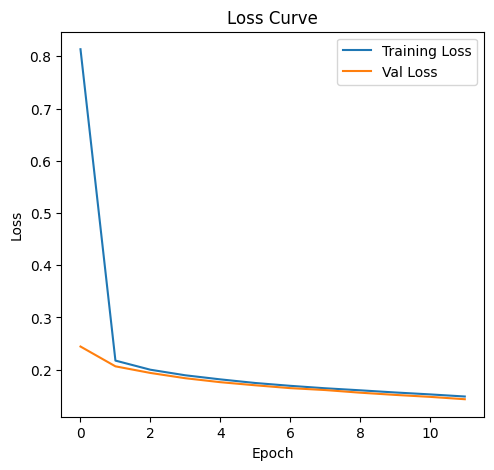

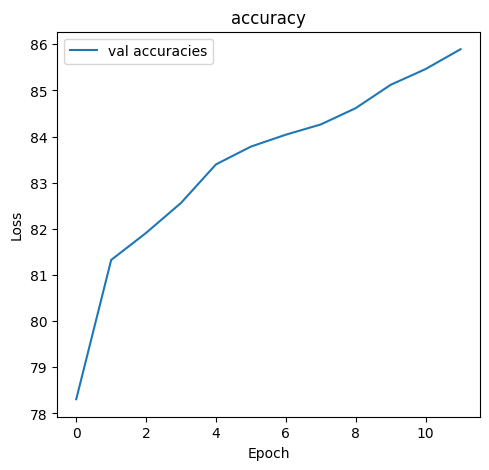

In [12]:
plt.figure(figsize=(12, 5))
# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(running_losses, label='Training Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 5))
# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='val accuracies')
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [14]:
full_val_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length, transform=transform, train=False, split=False)

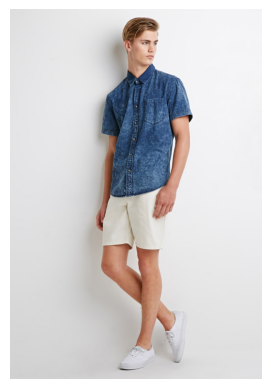

result:  This guy is wearing a short-sleeve shirt with pure color patterns and a three-point shorts. the shirt is with cotton fabric and its neckline is lapel. the shorts are with cotton fabric and pure color patterns. this person wears a ring. 

answer: The gentleman is wearing a short-sleeve shirt with pure color patterns. The shirt is with denim fabric. It has a lapel neckline. The gentleman wears a short pants. The pants are with cotton fabric and pure color patterns. 

rouge_l score:  0.6249999950086808


In [33]:
i = random.choice(range(len(full_val_set)))
image_path, description = full_val_set.get_pair(i)
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # 可选：关闭坐标轴
plt.show()


predicted_sequence = predict_sequence(image, model, vocabulary, start_seq='', device=device, max_seq_len=max_seq_length)
print('result: ', predicted_sequence, '\n')
print(f'answer:', description, '\n')
print('rouge_l score: ', calculate_rouge_l(predicted_sequence, description))